# Dense neural network
A dense neural network, also known as a fully connected neural network, builds off of a single neuron model by connecting multiple neurons into layers, where each neuron is connected to every neuron in the adjacent layers. Like a single neuron, each neuron in a dense neural network takes an input vector, processes it through an activation function, and produces an output. Each layer of neurons receives input from the previous layer. By stacking multiple layers of neurons, a dense neural network can learn to recognize patterns far more complex than a single neuron can. In fact, the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that any reasonable function can be approximated by a dense neural network as long as one neuron layer has a nonlinear activation function.

{IMAGE OF DNN}

We will implement, from scratch, a dense neural network. We will train this dense neural network to recognize handwritten numerals.

## MNIST handwritten digit database
The MNIST handwritten digit databse is a collection of images that is widely used as a benchmark dataset for training and testing machine learning algorithms in image recognition. It contains 70,000 grayscale images of handwritten digits (0 to 9), each of which is a 28x28 greyscale pixel image. The dataset is divided into two subsets: 60,000 images for training and 10,000 images for testing. The images were collected from a variety of sources, including high school students and US Census Bureau employees.

We can load the dataset via the `tensorflow.keras` package. `train_X` and `test_X` are stored as 3-dimensional tensors, where entry $i,j,k$ is the greyscale value of the pixel in row $j$, column $k$ of image sample $i$.

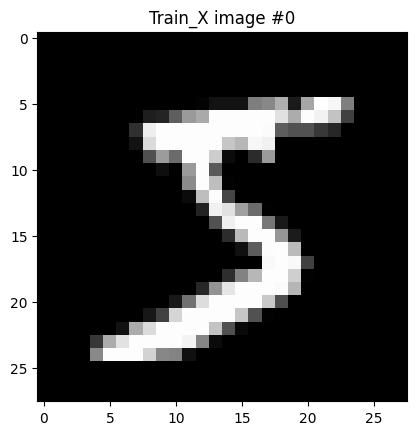

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras 
from sklearn import metrics

(train_X, train_y), (test_X, test_y) = keras.datasets.mnist.load_data()

# Show an example of an image
plt.imshow(train_X[0], cmap="gray")
plt.title("Train_X image #0")
plt.show()

## Data cleaning

### Scaling
The greyscale pixel values can have large variance, ranging between 0 and 255. Such large variance can lead to issues when training the weights and biases of our neurons. So we will scale all the greyscale values down to a range from 0 to 1 by dividing by 255.

### Image flattening
Additionally, the input layer to a dense neural network requires a vector as input. But our samples in `train_X` are 28-by-28 arrays. We can convert the arrays into vectors by flattening them: For a given array, stack the columns of the array into a single column vector. In this case, our input layer has size $28 \times 28 = 784$.

### One-hot encoding
Each image is labeled with a 0-9 category to denote which numeral is depicted by the handwriting. We can use one-hot encoding to represent the labels. For each image, create a 10-length binary array indexed 0-9, where the array is all zeros except for the one located at the index associated with the image's numeral label. This also means our output layer has size 10.

In [2]:
# Scale pixel values from 0-255 to 0-1
train_X = train_X / 255
test_X = test_X / 255

# Flatten training images and one-hot encode training labels
flat_train_X = []
onehot_train_y = []

for x_array, y_label in zip(train_X, train_y):
    flat_train_X.append(x_array.flatten().reshape(-1, 1))
    y_vec = np.zeros((10, 1), dtype=bool)
    y_vec[y_label][0] = 1
    onehot_train_y.append(y_vec)

# Flatten training images and one-hot encode training labels
flat_test_X = []
onehot_test_y = []

for x_array, y_label in zip(test_X, test_y):
    flat_test_X.append(x_array.flatten().reshape(-1, 1))
    y_vec = np.zeros((10, 1), dtype=bool)
    y_vec[y_label][0] = 1
    onehot_test_y.append(y_vec)

## Network architecture
Our dense neural network has 784-size input layer and 10-size output layer. There are $L$ total layers, where $L-2$ of these layers are the "hidden" intermediary layers between input and output. Arbitrarily, we will have two hidden layers, both of 60 neurons. (There is actually not a great way to decide how many hidden layers to employ until As for our single-neuron model, each of the neurons in our dense neural network must have a defined activation function and cost function.

We will use the sigmoid function for our activation function: $\sigma(z) = \frac{1}{1+e^{-z}}$

The sigmoid function has known derivative: $\frac{d}{dz} \sigma(z) = \sigma(z)(1 - \sigma(z))$

We will use the mean-squared error as our activation function: $C(W, b) = \frac{1}{2}\sum_{k=1}^{10}(\hat{y}^{(i)}_k - y^{(i)}_k)^2$

Training any neural network requires the following steps:
1. Initialize the weights of biases of each neuron in each layer.
2. Feedfoward phase to make a prediction.
3. Calculate the cost function.
4. Back-propogation with gradient descent to optimize weights and biases.

In [3]:
def sigmoid(z):
    '''
    Returns 1 / (1 + e^-z)
    '''
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z):
    '''
    Returns derivative of sigmoid: sigmoid(z) * (1 - sigmoid(z))
    '''
    return sigmoid(z) * (1 - sigmoid(z))

### Initialize weights
We must initialize our weights and biases randomly. One way is just initialize the weights and biases using a uniform or normal random distribution. However, Dr. Davila recommends the following initialization. It utilizes a scalar factor he found in a research paper that supposedly speeds up training.

In [4]:
def initialize_weights(layers=[784, 60, 60, 10]):
    '''
    Initializes weights and biases of each neuron in the dense neural network
    INPUT
        layers; list of natural numbers, where the ith entry describes the size of the ith neuron layer
    RETURNS
        W; list of numpy matrices, where the ith matrix contains the weights of neuron layer i
        B; list of numpy matrices, where the ith matrix contains the biases of neuron layer i        
    '''
    # Initialize W, B with dummy elements at index 0. This is because layer 0 is the input layer and has no neurons.
    # This maintains consistency so that python-list index i refers to the ith network layer.
    W = [np.zeros((1,1))]
    B = [np.zeros((1,1))]
    
    # Foreach layer, initialize weights and biases according to Dr. Davila's magic scaling factor
    for lay in range(1, len(layers)):
        w_temp = np.random.randn(layers[lay], layers[lay - 1]) * np.sqrt(2 / layers[lay - 1])
        b_temp = np.random.randn(layers[lay], 1) * np.sqrt(2 / layers[lay - 1])
        W.append(w_temp)
        B.append(b_temp)
    
    return W, B

### Feedforward phase to make a prediction
For each layer $l \in \{1, ..., L\}$, let $W^l, b^l, z^l, a^l$ be the weights, biases, preactivation values, and postactivation values of the neurons in that layer. Note that the first layer, the input layer, has no weights/biases/preactivation value, and the postiactivation value is equal to the input signal vector. We can compute these as follows. Observe the parallels to the single-neuron model. The preactivation functions are a linear function on the postactivation values of the previous layer.

\begin{align}
    z^l =& W^l a^{l-1} + b^l \\
    a^l =& \sigma(z^l)
\end{align}

Starting by using the input layer as the inputs to layer 2, we can compute the postactivation values of the neuron layers in sequential order until we reach the output layer. The postactivation values of the output layer are the neural network's prediction.

In [5]:
def forward_phase(W, B, input_vec, activation_function=sigmoid):
    '''
    Performs forward phase of the neural network described by weights W and biases B for input layer input_vec
    INPUTS
        W; list of numpy matrices, where the ith matrix contains the weights of neuron layer i
        B; list of numpy matrices, where the ith matrix contains the biases of neuron layer i        
        input_vec; input to neural network, as a numpy array
        activation_function; the activation function
    RETURNS
        postact; list of postactivation values of each layer
        preact; list of preactivation values of each layer
    '''
    # List stores the preactivation values. Useful for backpropagation gradient descent.
    # Dummy element at index 0. This is because layer 0 is the input layer and has no neurons.
    # This maintains consistency so that python-list index i refers to the ith network layer.
    preact = [np.zeros((1,1))]
    
    # List stores the postactivation values.Set layer 0 postactivation value to input vector
    postact = [input_vec]
    
    # Compute postactivation output for each layer
    for lay in range(1, len(W)):
        
        # Compute preactivation value
        preact.append(np.matmul(W[lay], postact[-1]) + B[lay])
        
        # Compute postactivation value
        postact.append(activation_function(preact[-1]))
    
    # Return output layer postactivation value
    return postact, preact

def predict(W, B, input_vec, activation_function=sigmoid):
    '''
    Makes a neural network prediction by selecting the index of the output layer postactivation vector with greatest value
    INPUTS
        W; list of numpy matrices, where the ith matrix contains the weights of neuron layer i
        B; list of numpy matrices, where the ith matrix contains the biases of neuron layer i        
        input_vec; input to neural network
        activation_function; the activation function
    OUTPUT
        argmax index of output layer postactivation function
    '''
    postact_list, _ = forward_phase(W, B, input_vec, activation_function)
    return np.argmax(postact_list[-1])

### Cost function
We select mean-squared error as our cost function.

In [6]:
def mse(predicted, actual):
    '''
    Returns the mean-squared error of a prediction
    INPUT
        predicted; list of predicted arrays
        actual; list of actual arrays
    RETURNS
        the MSE
    '''
    return 1 / 2 * np.sum(np.square(predicted - actual))

Just to demo our working neural network so far, let's see what we predict for the first image in the training set on our initial untrained weights and biases.

Prediction response vector:
[[0.77379906]
 [0.44344221]
 [0.29113338]
 [0.6498617 ]
 [0.52020362]
 [0.7263067 ]
 [0.1561438 ]
 [0.46460636]
 [0.50791904]
 [0.61396215]]
Prediction: 0
MSE: 1.2615879508941568


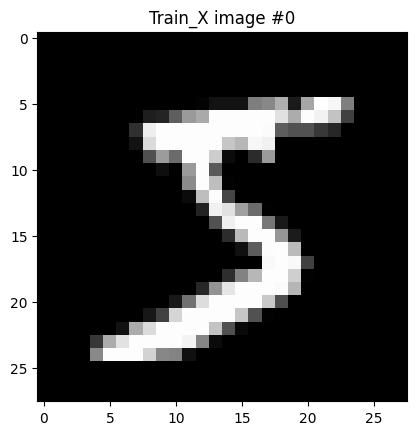

In [7]:
# Initialize weights
W, B = initialize_weights()

# Forward phase to make prediction
postact_list, preact_list = forward_phase(W, B, flat_train_X[0])

# Show the output prediction
print("Prediction response vector:")
predicted = postact_list[-1]
print(predicted)

print("Prediction: " + str(np.argmax(predicted)))


# Show MSE of prediction
actual = onehot_train_y[0]
print("MSE: " + str(mse(predicted, actual)))

# Show original numeral image
plt.imshow(train_X[0], cmap="gray")
plt.title("Train_X image #0")
plt.show()

### Back-propogation with gradient descent to optimize weights and biases
Backpropagation is a technique for updating the weights and biases for a neural network. We will omit the proof of why backpropogation works because it is quite complex, but the [Wikipedia page](https://en.wikipedia.org/wiki/Backpropagation) has a good explanantion. The process is as follows so some learning rate $\alpha$:
1. $\delta^L = \nabla_a C \otimes \frac{d}{dz} \sigma(z^L) = (a^L - y) \otimes \frac{d}{dz} \sigma(z^L)$
2. $\forall l = L-1, ..., 1, \delta^l = ((w ^ {l + 1}) ^ T \delta ^ {l + 1}) \otimes \frac{d}{dz} \sigma(z ^ l)$
3. $\forall l = 1, ..., L$:
 1. $w^l \gets w^l - \alpha \delta^l (a^{l-1}) ^ T$
 2. $b^l \gets b^l - \alpha \delta^l$

In [8]:
def backpropogation(W, B, actual, postact_list, preact_list, alpha=0.1, activation_gradient=d_sigmoid):
    '''
    Updates neurons' weights and biases via backpropagation gradient descent.
    INPUT
        W; list of numpy matrices, where the ith matrix contains the weights of neuron layer i
        B; list of numpy matrices, where the ith matrix contains the biases of neuron layer i        
        actual; the actual vector associated with this training sample
        postact_list; list of numpy matrices, where the ith matrix contains the postactivation values computed by layer i
        preact_list; list of numpy matrices, where the ith matrix contains the preactivation values computed by layer i
        alpha; positive scalar learning rate
        activation_gradient; the gradient of the activation function
    OUTPUT
        W and B after being updated by gradient descent
    '''
    # Initialize deltas and find delta of last layer
    deltas = [None] * len(W)
    deltas[-1] = np.multiply((postact_list[-1] - actual), activation_gradient(preact_list[-1]))

    # Find delta of layers in backward order
    for lay in range(len(W) - 2, 0, -1):
        deltas[lay] = np.multiply(np.matmul(np.transpose(W[lay + 1]), deltas[lay + 1]),
                                  activation_gradient(preact_list[lay]))
    
    # Adjust weights and biases
    for lay in range(1, len(W)):
        W[lay] -= alpha * np.matmul(deltas[lay], np.transpose(postact_list[lay - 1]))
        B[lay] -= alpha * deltas[lay]
    
    return W, B
    

### Put it all together
We have now coded all the separate elements of our dense neural network! Let's put it all into a single class.

In [9]:
class DenseNeuralNetwork:
    '''
    This object represents a dense neural network.
    '''
    
    layers = []  # list of natural numbers, where the ith entry describes the size of the ith neuron layer
    n_layer = 0  # number of layers
    W = []       # list of numpy matrices, where the ith matrix contains the weights of neuron layer i
    B = []       # list of numpy matrices, where the ith matrix contains the biases of neuron layer i 
    activation_function = None  # the activation function; input is a numpy array; return is a numpy array of equal dimension
    activation_gradient = None  # the gradient of the activation function; input a numpy array; return is a numpy array of equal dimension
    
    def __init__(self, layers=[784, 60, 60, 10], activation_function=sigmoid, activation_gradient=d_sigmoid):
        '''
        Initializes DenseNeuralNetwork object
        INPUT
            layers; list of natural numbers, where the ith entry describes the size of the ith neuron layer
            activation_function; the activation function
            activation_gradient; the gradient of the activation function
        '''
        self.layers = layers
        self.n_layer = len(layers)
        self.activation_function = activation_function
        self.activation_gradient = activation_gradient
        self.initialize_weights()
    
    def initialize_weights(self):
        '''
        Initializes weights W and biases B of each neuron in the dense neural network
        '''
        # Initialize W, B with dummy elements at index 0. This is because layer 0 is the input layer and has no neurons.
        # This maintains consistency so that python-list index i refers to the ith network layer.
        self.W = [np.zeros((1,1))]
        self.B = [np.zeros((1,1))]

        # Foreach layer, initialize weights and biases according to Dr. Davila's magic scaling factor
        for lay in range(1, len(self.layers)):
            w_temp = np.random.randn(self.layers[lay], self.layers[lay - 1]) * np.sqrt(2 / self.layers[lay - 1])
            b_temp = np.random.randn(self.layers[lay], 1) * np.sqrt(2 / self.layers[lay - 1])
            self.W.append(w_temp)
            self.B.append(b_temp)
            
    def forward_phase(self, input_vec):
        '''
        Performs forward phase of the neural network described by weights W and biases B for input layer input_vec
        INPUTS
            input_vec; input to neural network, as a numpy array
        RETURNS
            postact; list of postactivation values of each layer
            preact; list of preactivation values of each layer
        '''
        # List stores the preactivation values. Useful for backpropagation gradient descent.
        # Dummy element at index 0. This is because layer 0 is the input layer and has no neurons.
        # This maintains consistency so that python-list index i refers to the ith network layer.
        preact = [np.zeros((1,1))]

        # List stores the postactivation values.Set layer 0 postactivation value to input vector
        postact = [input_vec]

        # Compute postactivation output for each layer
        for lay in range(1, self.n_layer):

            # Compute preactivation value
            preact.append(np.matmul(self.W[lay], postact[-1]) + self.B[lay])

            # Compute postactivation value
            postact.append(self.activation_function(preact[-1]))

        # Return output layer postactivation value
        return postact, preact
        
    def predict(self, input_vec):
        '''
        Makes a neural network prediction by selecting the index of the output layer postactivation vector with greatest value
        INPUTS
            input_vec; input to neural network, as a numpy array
        OUTPUT
            argmax index of output layer postactivation function
        '''
        postact_list, _ = self.forward_phase(input_vec)
        return np.argmax(postact_list[-1])
    
    def backpropagation(self, actual, postact_list, preact_list, alpha=0.4):
        '''
        Updates neurons' weights and biases via backpropagation gradient descent.
        Assumes MSE is the cost function.
        INPUT
            actual; the actual response vector associated with this training sample
            postact_list; list of numpy matrices, where the ith matrix contains the postactivation values computed by layer i
            preact_list; list of numpy matrices, where the ith matrix contains the preactivation values computed by layer i
            alpha; positive scalar learning rate
        '''
        # Initialize deltas and find delta of last layer
        deltas = [None] * self.n_layer
        deltas[-1] = np.multiply((postact_list[-1] - actual), self.activation_gradient(preact_list[-1]))

        # Find delta of layers in backward order
        for lay in range(self.n_layer - 2, 0, -1):
            deltas[lay] = np.multiply(np.matmul(np.transpose(self.W[lay + 1]), deltas[lay + 1]),
                                      self.activation_gradient(preact_list[lay]))

        # Adjust weights and biases
        for lay in range(1, self.n_layer):
            self.W[lay] -= alpha * np.matmul(deltas[lay], np.transpose(postact_list[lay - 1]))
            self.B[lay] -= alpha * deltas[lay]
            
    def train(self, x_train, y_train, n_epoch=5, alpha=0.4):
        '''
        Trains this dense neural network
        INPUT
            x_train; list of input vectors for training
            y_train; list of actual response vectors for training
            n_epoch; number of training epochs
            alpha; positive scalar learning rate
        RETURNS
            list of the sum of squared error across each epoch
        '''
        # Initialize list to store sum of squared error each epoch
        sum_sq_errors = []
        
        # For each epoch, train via stochastic gradient descent across all training samples
        for epoch in range(n_epoch):
            sum_sq_errors.append(0)
            
            # Progress bar
            prog = tqdm(range(len(x_train)))
            prog.set_description("Epoch #" + str(epoch))
            prog.update()
                        
            # Make a prediction foreach sample, then backpropagate
            for ind in prog:
                x_input = x_train[ind]
                y_response = y_train[ind]
                postact_list, preact_list = self.forward_phase(x_input)
                self.backpropagation(y_response, postact_list, preact_list, alpha)
                sum_sq_errors[-1] += np.sum(np.square(postact_list[-1] - y_response))
                
        return sum_sq_errors
    
    def batch_predict(self, x_test, y_test=None):
        '''
        Makes several predictions at once.
        INPUT
            x_test; list of input vectors
            y_test; list of actual response vectors. Argument is optional; if argument is provided, displays confusion matrix.
        RETURN
            predictions; list of the neural network predicted labels
        '''
        # List stores our predictions over the testing dataset
        predictions = []

        # Predictions across the testing dataset
        for x_input in tqdm(x_test):
            predictions.append(dnn.predict(x_input))

        # Show confusion matrix and other metrics
        confusion_matrix = metrics.confusion_matrix(y_test, predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
        cm_display.plot()
        plt.show()
        
        return predictions

For fun, let's see how an untrained model performs when attempting to predict the testing dataset.

100%|██████████| 10000/10000 [00:01<00:00, 5242.06it/s]


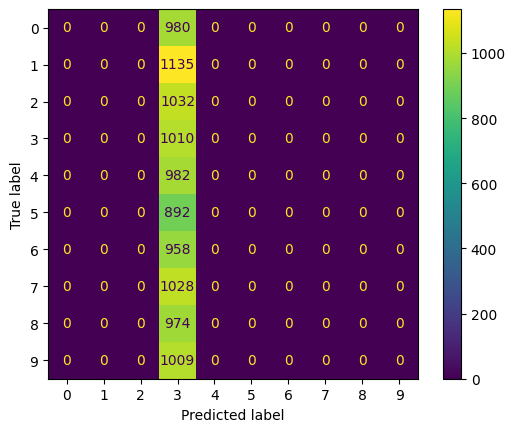

In [10]:
# Initialize model
dnn = DenseNeuralNetwork()
_ = dnn.batch_predict(flat_test_X, test_y.tolist())

As expected, the untrained model is quite bad. What happens after we train the model?

Epoch #0: : 60001it [00:33, 1767.59it/s]                         
Epoch #1: : 60001it [00:32, 1860.77it/s]                         
Epoch #2: : 60001it [00:31, 1895.36it/s]                         
Epoch #3: : 60001it [00:31, 1888.55it/s]                         
Epoch #4: : 60001it [00:32, 1871.31it/s]                         


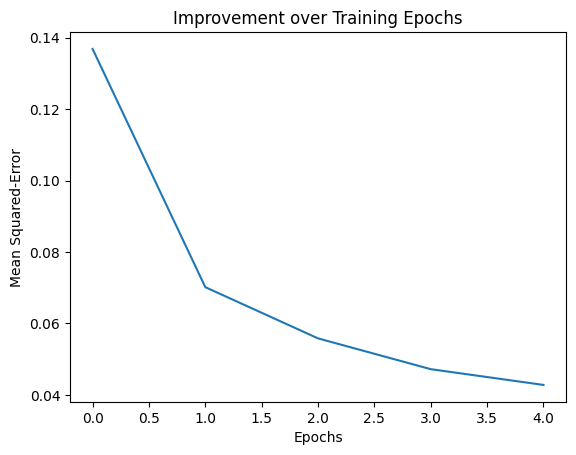

In [11]:
# Train model
sse_list = dnn.train(flat_train_X, onehot_train_y, n_epoch=5)

# Show model progression
plt.plot([sse / len(flat_train_X) for sse in sse_list])
plt.title("Improvement over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared-Error")
plt.show()

### Model performance
It looks like the neural network outputs improve steadily each epoch. After the last epoch, the mean-squared error is . Let's see how the model performs on th testing dataset.

100%|██████████| 10000/10000 [00:01<00:00, 5496.72it/s]


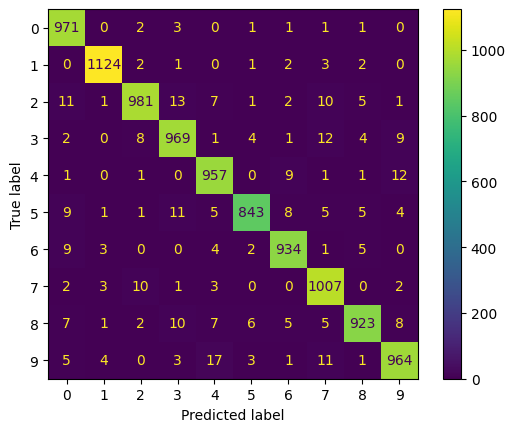

In [12]:
prediction = dnn.batch_predict(flat_test_X, test_y.tolist())

In [13]:
print(metrics.classification_report(test_y.tolist(), prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.95      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.98      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.95      0.98      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



These results look great! The confusion matrix indicates our neural network makes the correct numeral prediction almost every time. The 97% precision indicates that 97% of predicted numerals were correct guesses. The 97% recall indicates that 97% of the true numerals are predicted correctly. These are fantastic results, especially since the neural network was built from scratch. For fun, let's see some of these predictions.

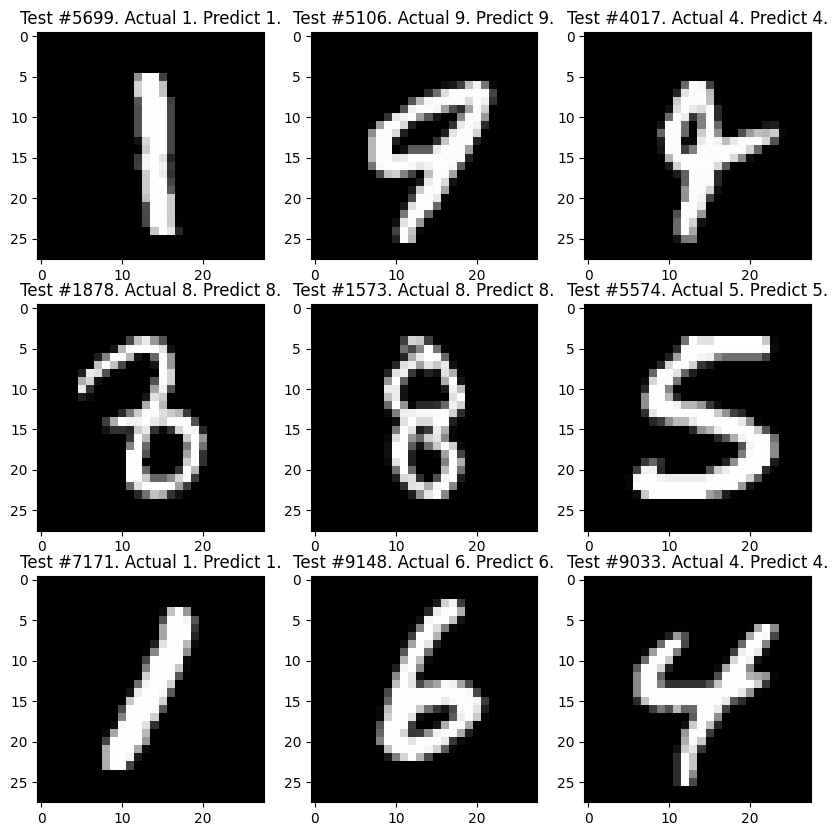

In [14]:
import random
import matplotlib.gridspec as gridspec

# Create subplots of each tested sample
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(10, 10))

for sample in range(9):
    ind = random.randint(0, len(test_X))
    ax = plt.subplot(gs[int(sample / 3), sample % 3])
    fig = plt.imshow(test_X[ind], cmap="gray")
    ax.set_title("Test #" + str(ind) + ". Actual " + str(test_y[ind]) + ". Predict " + str(dnn.predict(flat_test_X[ind])) + ".")